<a href="https://colab.research.google.com/github/aysekonus/movie_recommendation_system/blob/main/Huawei_Internship_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# to connect database using sqlite

import sqlite3

con = sqlite3.connect("/content/movielens-small.db")
cursor = con.cursor()

## DATASET INFORMATION:
---
- **ratings.csv**
```
userId, movieId, rating, timestamp
```
- **tags.csv**
```
userId, movieId, tag, timestamp
```
- **movies.csv**
```
movieId, title, year, genres
```
- **links.csv**
```
movieId, imdbId, tmdbId
```

# **TASK - 1: Exploratory Data Analysis**
---
- **Write a SQL query to create a dataframe with including userid, movieid, genre and rating** : `read_dataframe()`
- **Count ratings for each movie, and list top 5 movies with the highest value** : `list_top5count_movies()`
- **Find and list top 5 most rated genres** : `list_top5rated_genres()`

In [ ]:
# function to create dataframe with including userid, movieid, genre and rating
def read_dataframe():
  cursor.execute("SELECT ratings.userId, ratings.movieid, movies.genres, ratings.rating FROM ratings JOIN movies ON ratings.movieId = movies.movieId")
  data = cursor.fetchall()

  print("USER_ID, MOVIE_ID, GENRE, RATING\n--------------------------------------------")
  for i in data:
    print(i)

# function to create dataframe that has count ratings for each movie and list top 5 movies with the highest value of count ratings
def list_top5count_movies():
  cursor.execute("SELECT title, COUNT(rating) as count_rating FROM movies m JOIN ratings r ON m.movieId = r.movieId GROUP BY title ORDER BY count_rating DESC LIMIT 5")
  data = cursor.fetchall()

  print("(MOVIE TITLE, COUNT OF RATING)\n-------------------------------")
  for i in data:
    print(i)

# function to find and list top 5 most rated genres
def list_top5rated_genres():
  cursor.execute("SELECT genres, SUM(rating) as Sum_Rating FROM movies m JOIN ratings r ON m.movieId = r.movieId GROUP BY genres ORDER BY Sum_Rating DESC LIMIT 5")
  data = cursor.fetchall()

  print("(MOVIE GENRE, SUM OF RATINGS)\n-------------------------------")
  for i in data:
    print(i)

In [ ]:
# read_dataframe()
# list_top5count_movies()
list_top5rated_genres()

(MOVIE GENRE, SUM OF RATINGS)
-------------------------------
('Drama', 25650.0)
('Comedy', 20529.5)
('Comedy|Romance', 12930.5)
('Drama|Romance', 11295.5)
('Comedy|Drama', 10709.5)


# **TASK - 2: Recommender Design**
---

- **Train a recommender model, one by using user ratings (please prefer a model under PySpark MLlib)**
- **Present your model outputs by using essential metrics**

> ## Requirements
```
!pip install pyspark
```





In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 59.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0f3b2d8273643923b0237eba484f545cf8dd035130f8f829fe7516a6a8a2cc31
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# for machine learning processes
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# for dataframe and spark session processes
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.context import SparkContext
from datetime import date, timedelta, datetime
import time

> **Functions required to create the dataset file containing the rating data (User_Id, Movie_Id, Rating) required for the recommendation system model:**

- **`create_table()`** : to create the dataset file
- **`insert_data()`** : to transfer data from the database to the data set created
- **`ratings_show()`** : displays data to verify that the dataset has been created




In [ ]:
def create_table():
  cursor.execute("CREATE TABLE movie_ratings (User_Id int, Movie_Id INT, Rating FLOAT)")
  data = cursor.fetchall()

def insert_data():
  cursor.execute("INSERT INTO movie_ratings (User_Id, Movie_Id, Rating) SELECT userid, m.movieid, r.rating FROM movies m JOIN ratings r ON m.movieId = r.movieId")
  data = cursor.fetchall() 

def ratings_show():
  cursor.execute("SELECT * FROM movie_ratings LIMIT 5")
  data = cursor.fetchall() 
  for i in data:
    print(i)

create_table()
insert_data()
ratings_show()

(7, 1, 5.0)
(10, 1, 4.0)
(13, 1, 4.5)
(16, 1, 5.0)
(21, 1, 5.0)


> **Functions required to create the dataset file containing the movie informations (Movie Id, Movie Genre and Movie Title) required for the recommendation system model:**

- **`create_table()`** : to create the dataset file
- **`insert_data()`** : to transfer data from the database to the data set created
- **`movies_show()`** : displays data to verify that the dataset has been created


In [ ]:
def create_table():
  cursor.execute("CREATE TABLE movies_2 (Movie_Id INT, Genres VARCHAR(255), Title VARCHAR(255))")
  data = cursor.fetchall()

def insert_data():
  cursor.execute("INSERT INTO movies_2 (Movie_Id, Genres, Title) SELECT movieid, genres, title FROM movies")
  data = cursor.fetchall() 

def movies_show():
  cursor.execute("SELECT * FROM movies_2 LIMIT 5")
  data = cursor.fetchall() 
  for i in data:
    print(i)

# create_table()
# insert_data()
movies_show()

(1, 'Adventure|Animation|Children|Comedy|Fantasy', 'Toy Story')
(2, 'Adventure|Children|Fantasy', 'Jumanji')
(3, 'Comedy|Romance', 'Grumpier Old Men')
(4, 'Comedy|Drama|Romance', 'Waiting to Exhale')
(5, 'Comedy', 'Father of the Bride Part II')


In [ ]:
# to start spark session
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

## **1.** Load The Datasets

> **The file - folder relationship is as shown in the figure:**

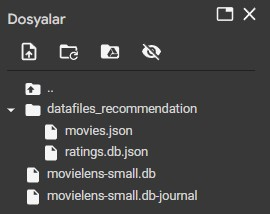

In [ ]:
ratings  = spark.read.json('/content/datafiles_recommendation/ratings.db.json')
movies  = spark.read.json('/content/datafiles_recommendation/movies.json')

In [ ]:
# to verify that it was created correctly by viewing part of the dataset

ratings.show(3)
# ratings.printSchema()
# ratings.describe().show()

+--------+------+-------+
|Movie_Id|Rating|User_Id|
+--------+------+-------+
|       1|   5.0|      7|
|       1|   4.0|     10|
|       1|   4.5|     13|
+--------+------+-------+
only showing top 3 rows



In [ ]:
# to verify that it was created correctly by viewing part of the dataset

movies.show(3)
# movies.printSchema()
# movies.describe().show()

+--------------------+--------+----------------+
|              Genres|Movie_Id|           Title|
+--------------------+--------+----------------+
|Adventure|Animati...|       1|       Toy Story|
|Adventure|Childre...|       2|         Jumanji|
|      Comedy|Romance|       3|Grumpier Old Men|
+--------------------+--------+----------------+
only showing top 3 rows



### **To examine the density status of the dataset (sparsity)**

In [ ]:
# Count the total number of ratings in the dataset
numerator = ratings.select("Rating").count() 

# Count the number of distinct User_Ids and distinct Movie_Ids
num_users = ratings.select("User_Id").distinct().count()
num_movies = ratings.select("Movie_Id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is", "%.2f" % sparsity + "% empty.")

The ratings dataframe is 98.34% empty.


### **To interpret ratings**

> **To find out how many ratings users generally have for movies and to see how many ratings each movie has**

In [ ]:
userId_ratings = ratings.groupBy("User_Id").count().orderBy('count', ascending=False)
userId_ratings.show(5)

+-------+-----+
|User_Id|count|
+-------+-----+
|    516| 2268|
|    384| 1412|
|    187| 1338|
|     31| 1283|
|    377| 1241|
+-------+-----+
only showing top 5 rows



In [ ]:
# Group data by userId, count ratings
movieId_ratings = ratings.groupBy("Movie_Id").count().orderBy('count', ascending=False)
movieId_ratings.show(5)

+--------+-----+
|Movie_Id|count|
+--------+-----+
|     593|  337|
|     318|  328|
|     296|  327|
|     480|  324|
|     356|  318|
+--------+-----+
only showing top 5 rows



## 2- **Let's Build Out An Alternating Least Square Model for Recommendation System**



In [ ]:
# Create test and train set
(train, test) = ratings.randomSplit([0.7, 0.3], seed=42)

# Create Alternating Least Square Model
als = ALS(userCol="User_Id", itemCol="Movie_Id", ratingCol="Rating", coldStartStrategy="drop", nonnegative=True)

### Configure Spark to tune ALS model


In [ ]:
# hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder()\
            .addGrid(als.rank, [12,13,14])\
            .addGrid(als.maxIter, [18,19,20])\
            .addGrid(als.regParam, [.17, .18, .19])\
            .build()

# Defining evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

In [ ]:
# to build validation pipeline
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator)

### **To set best model and best model parameters for recommendation system**

In [ ]:
model = tvs.fit(train)

In [ ]:
best_model = model.bestModel

In [ ]:
test_predictions = best_model.transform(test)
test_predictions.show()

+--------+------+-------+----------+
|Movie_Id|Rating|User_Id|prediction|
+--------+------+-------+----------+
|       1|   5.0|    463|  3.714744|
|      39|   4.0|    463| 2.9265532|
|      50|   5.0|    471| 4.2191024|
|     223|   4.0|    463| 3.6979783|
|     296|   3.5|    463| 3.7659485|
|     356|   2.5|    463| 3.7481034|
|     364|   4.0|    463| 3.5133514|
|     431|   0.5|    496| 2.6126382|
|     480|   3.0|    463|  3.363496|
|     593|   0.5|    463| 3.9473886|
|     858|   3.0|    463|  4.002961|
|    1022|   4.0|    496| 1.8810195|
|    1263|   3.0|    148|  3.307123|
|    1271|   2.5|    496| 2.5144684|
|    1350|   2.0|    463| 3.5871649|
|    1357|   2.5|    496| 2.3616364|
|    1380|   3.5|    463| 2.7687407|
|    1663|   2.0|    496| 2.3664596|
|    1682|   4.0|    463| 3.7895508|
|    1805|   3.0|    463| 2.8645997|
+--------+------+-------+----------+
only showing top 20 rows



In [ ]:
# View the predictions
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.9358478101821549


In [ ]:
print("Best Model")
print("-------------")

print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

Best Model
-------------
  Rank: 14
  MaxIter: 18
  RegParam: 0.18


## **3- Create The Recommendation System**

In [ ]:
# Generate n (ex: 10) Recommendations for all users

nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+--------------------+
|User_Id|     recommendations|
+-------+--------------------+
|      1|[{61742, 4.626641...|
|      3|[{8675, 5.818129}...|
|      5|[{2647, 4.62478},...|
|      6|[{8675, 4.4502645...|
|      9|[{8675, 5.3346553...|
|     12|[{31785, 4.403877...|
|     13|[{8675, 5.124443}...|
|     15|[{7669, 4.8727922...|
|     16|[{5792, 4.7523603...|
|     17|[{3466, 4.4046903...|
+-------+--------------------+



In [ ]:
# to split the recommendation column into 2 separate columns to bring the table to the format we want

nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('User_Id', col("rec_exp.Movie_Id"), col("rec_exp.Rating"))

nrecommendations.limit(10).show()

+-------+--------+---------+
|User_Id|Movie_Id|   Rating|
+-------+--------+---------+
|      1|   61742|4.6266413|
|      1|   57910|4.6266413|
|      1|    8675|4.6143594|
|      1|    7070|4.5916395|
|      1|    4710|4.5321174|
|      1|    2457|4.3114796|
|      1|    8491|4.2861776|
|      1|   26840|4.2495356|
|      1|   97172|4.2027597|
|      1|   52579|4.2027597|
+-------+--------+---------+



## 4- RECOMMENDATION SYSTEM

> **Movie recommendation system that filters the User_Id information according to the user we want and lists the most compatible movies for that user.**

Please edit the filter `.filter("User_Id = N")` with the **user's ID** (N) according to the user you want.

In [ ]:
nrecommendations.join(movies, on='Movie_Id').filter('User_Id = 100').sort('rating', ascending=False).limit(10).show()

+--------+-------+---------+--------------------+--------------------+
|Movie_Id|User_Id|   Rating|              Genres|               Title|
+--------+-------+---------+--------------------+--------------------+
|    8675|    100| 5.232433|    Action|Drama|War|    Enemy Below, The|
|    7070|    100| 4.972743|Action|Adventure|...|           Red River|
|   57910|    100|4.9353347|       Comedy|Horror|               Teeth|
|   61742|    100|4.9353347|         Documentary|Maradona by Kustu...|
|    4710|    100|4.8961687|       Drama|Western|       Shootist, The|
|      80|    100|4.8941445|      Children|Drama|White Balloon, Th...|
|    1450|    100|4.7797093|                 War|Prisoner of the M...|
|     764|    100|4.7797093|       Drama|Romance|               Heavy|
|    6216|    100| 4.759422|               Drama|Nowhere in Africa...|
|    1400|    100|4.7593737|               Drama| Somebody is Waiting|
+--------+-------+---------+--------------------+--------------------+

